# Route Vizualization
### Huanlin Dai

Proof of concept: graphing routes

In [2]:
import pandas as pd
import folium
import geopandas
from geodatasets import get_path
import matplotlib
import contextily as cx
from shapely.geometry import LineString
import osmnx as ox
import networkx as nx

In [3]:
route_1_data = pd.read_csv("../data/route1.csv")
route_2_data = pd.read_csv("../data/route2.csv")
coords1 = route_1_data[['Longitude', 'Latitude']]
coords2 = route_2_data[['Longitude', 'Latitude']]

In [4]:
place = "Galveston, Texas, USA"
galv_map = folium.Map(location = [29.30135, -94.7977], tiles ='OpenStreetMap', zoom_start=11)
galv_graph = ox.graph_from_place(place, network_type='drive')
north, south, east, west = [29.365913, 29.078869, -94.711952, -95.132866]
galv_graph = ox.truncate.truncate_graph_bbox(galv_graph, north, south, east, west, truncate_by_edge=False, retain_all=False, quadrat_width=0.05, min_num=3)

In [20]:
def calc_routes(graph, coords):
    """
    Takes in a graph and a set of coordinates (w/ columns "Longitude" and "Latitude")
    and returns the set of shortest routes between each coordinate

    Parameters:
        graph : osmnx graph
        coords : dataframe
    Returns:
        routes: list of routes
        
    """
    routes = []
    for i in range(len(coords) - 1):
        start_node = ox.nearest_nodes(graph, coords.iloc[i]['Longitude'], coords.iloc[i]['Latitude'])
        end_node = ox.nearest_nodes(graph, coords.iloc[i+1]['Longitude'], coords.iloc[i+1]['Latitude'])
        routes.append(nx.shortest_path(graph, start_node, end_node, weight='length'))
    return routes

In [21]:
routes_1 = calc_routes(galv_graph, coords1)

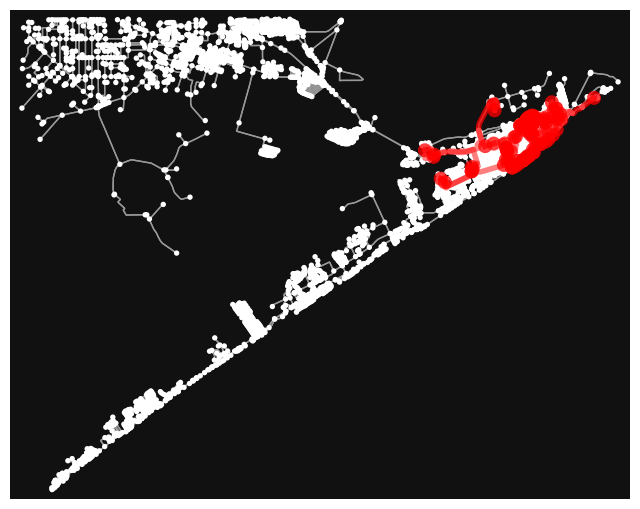

In [22]:
route_1_plot = ox.plot_graph_routes(galv_graph, routes_1)

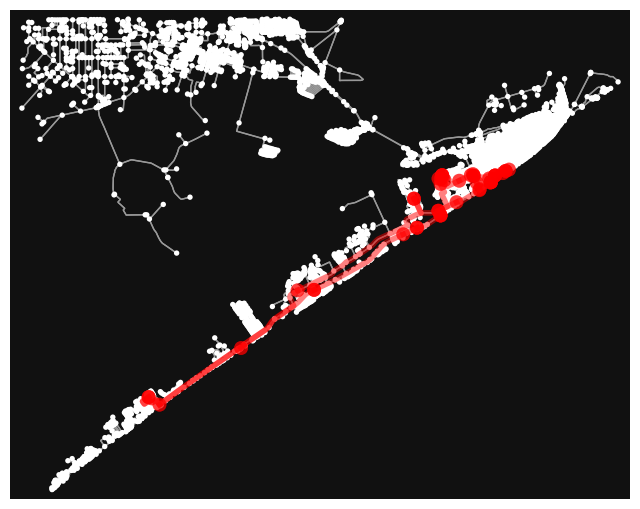

In [23]:
routes_2 = calc_routes(galv_graph, coords2)
route_2_plot = ox.plot_graph_routes(galv_graph, routes_2)

In [24]:
# For future graph improvements
# for point in range(0, len(locations_list)):
#     folium.Marker(route1[point], popup=feu_galveston['Name'][point]).add_to(galveston_map)
# nodes, streets = ox.graph_to_gdfs(graph)